# Part 6.3 - Analysis Topic Model of WWI
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics, plot_wordcloud, plot_heatmap, plot_avg
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-03 17:27:11


**In this part, we will use the topic modeling result from part 6.1 to analyze the WWI time.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/wwi/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
0,0,0.001607,train railway leave trains station passengers return dep day tickets service stations express run railways fares spe...
1,1,0.004432,prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...
2,2,0.008014,time good year made great present work years fact number past season week large make place success doubt interest ago
3,3,0.002558,plaintiff defendant claim court costs judgment case witness evidence paid amount pay appeared gave made plaintiffs c...
4,4,0.005621,found death body deceased man inquest dead named evidence witness died suicide morning murder wife returned house ve...


**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/wwi/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (567878, 6)


,id,region,year,topic,weight,keywords
498320,27571534,Auckland,1912-03,52,0.155798,tin tins tea soap sugar jam jars dozen prices large doz lod ...
246759,23586158,Manawatu-Wanganui,1912-12,33,0.237316,tin ill oil lit mil day zealand ton tie hat aro fur aid tins...
153780,16687115,Gisborne,1918-01,153,0.302308,company miss opera theatre orchestra night house music seaso...
276933,24242704,Taranaki,1912-10,21,0.203355,public time present question people great fact matter good m...
567474,34806922,Taranaki,1919-09,28,0.151864,trade new_zealand prices price cent goods industry market pr...


**Average topic weight dataframe:**

In [6]:
path = r'../models/wwi/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (24000, 4)


,year,topic,weight,keywords
20281,1920-06,81,0.004712,building feet work room buildings exhibition art built large...
6776,1914-10,176,0.004367,estate creditors trustee bankruptcy public trust bankrupt ac...
21944,1921-02,144,0.000407,extract sander eucalypti sons eucalyptus sander's medical ad...
23531,1921-10,131,0.010418,messrs smith brown wilson misses mrs jones williams taylor m...
3486,1913-06,86,0.004226,john james william george thomas henry charles robert sir ed...


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

,id,region,year,topic,weight,keywords
137247,16541987,West Coast,1919-06,178,0.938912,books book illustrated library history works life new_zealan...
118475,16339089,West Coast,1917-12,87,0.927084,pills ointment blood diseases cure skin medicine complaints ...
118512,16339664,West Coast,1917-12,87,0.924864,pills ointment blood diseases cure skin medicine complaints ...


In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

16541987

In [10]:
%%bash -s $id_

echo 'Print 2000 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 16541987
1561598:16541987	TIDES.	TIDES.June 6—3.15 a.m; 3.42 p.m. June 7 — 4.10 a.m.; 4.35 p.m. June 8 — 5.5 a.m.; 5.40 p.m. June 9— 6.10 a.m; 6.43 p.m. June 10—7.12 a.m.; 7.40 p.m. June 11— 8.10 a.m.; 8.35 p.m. June 12 — 9.5 a.m ; 9.30 p.m. June 13 — 9.57 a.m.; 10.20 p.m. June 14c — 10.40 a.m; 11.4 p.m. June 15 — 11.25 a.m.; 11.47 p.m. June 16 ; 0.10 p.m. June 17 — 0.33 a.m; 0.53 p.m. June 18—1.18 a.m; 1.40 p.m. Jttue 19—2.5 a.m.; 2.28 p.m. June 20 — 2.55 a.m.; 3.23 p.m. June 21 — 3.50 a.m; 4.20 p.m. June 22—4.50 a.m; 5.26 p.m. June 23—6.2 a.m ; 6.35 p.m. June 24 — 7.7 a.m; 7.37 p.m. June 25 — 8.3 a.m: 8.30 p.m. June 26—8.57 a.m: 9.23 p.m. June 27 — 9.47 a.m; 10.11 p.m. June 28—10.34 a.m; 10.54 p.m. June 29—11.15 a.m; 11.34 ' p.m. June 30 — 11.53 a.m-.


## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the highest weight 20 topics in topics list.**

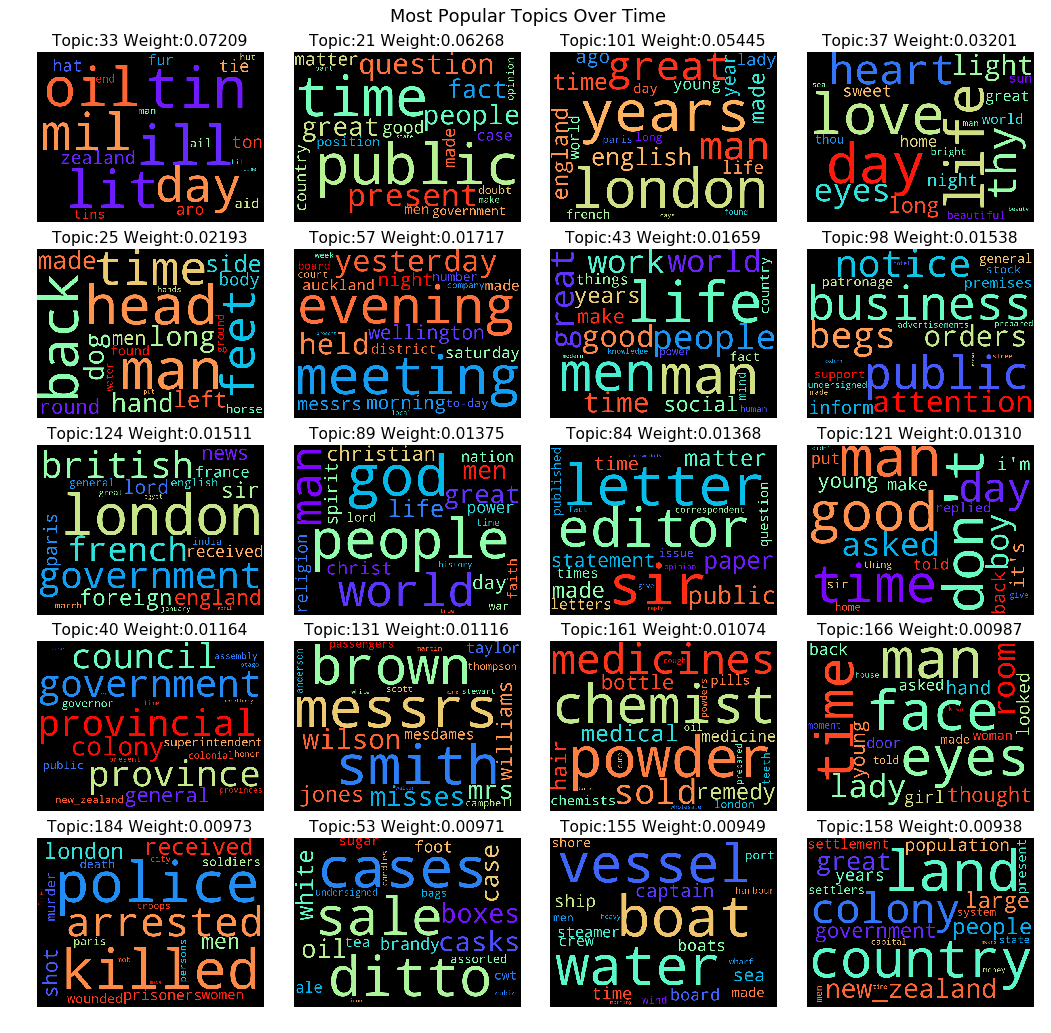

In [11]:
df_plt = df_topics.copy(deep=True).sort_values(by='weight', ascending=False)

plot_wordcloud(df_plt, 20, 20, 4)

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

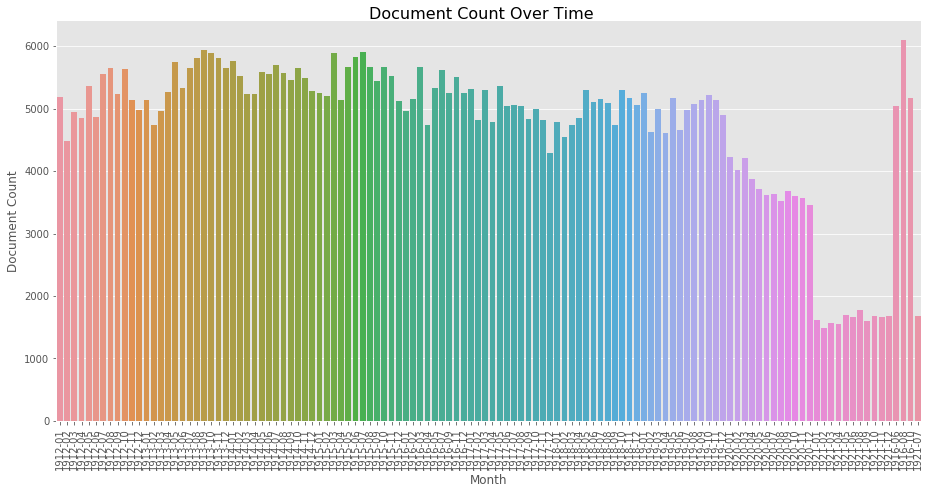

In [12]:
g = sns.catplot(x="year",
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Time", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Month', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general, each point represents a document in a certainn year with certain dominant topic weight, the color changes over time.**

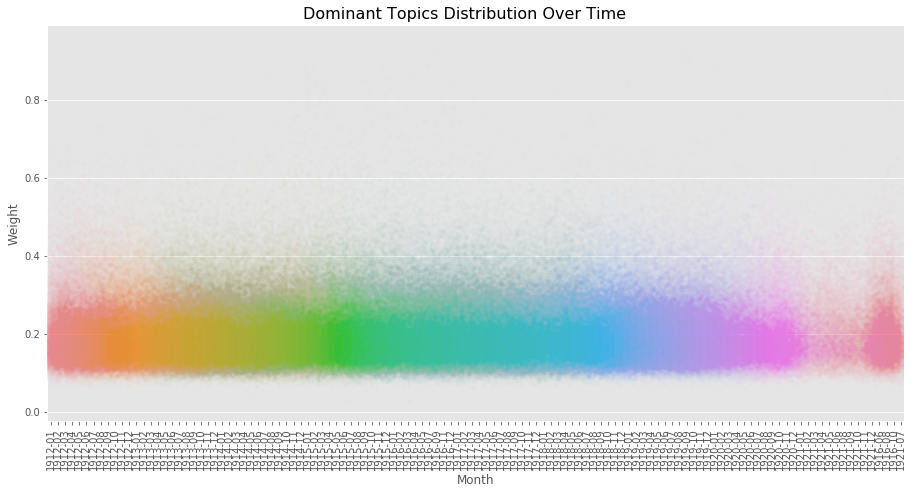

In [13]:
g = sns.catplot(x="year", y='weight',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=4, alpha=0.01,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Time", fontsize=16)
g.set(xlabel='Month', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Monthly Average Weight Distribution

**We plot all the monthly average weight to see the general distribution:**

In [14]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt_scaled.head()

year,1912-01,1912-02,1912-03,1912-04,1912-05,1912-06,1912-07,1912-08,1912-09,1912-10,1912-11,1912-12,1913-01,1913-02,1913-03,1913-04,1913-05,1913-06,1913-07,1913-08,1913-09,1913-10,1913-11,1913-12,1914-01,1914-02,1914-03,1914-04,1914-05,1914-06,1914-07,1914-08,1914-09,1914-10,1914-11,1914-12,1915-01,1915-02,1915-03,1915-04,1915-05,1915-06,1915-07,1915-08,1915-09,1915-10,1915-11,1915-12,1916-01,1916-02,1916-03,1916-04,1916-05,1916-06,1916-07,1916-08,1916-09,1916-10,1916-11,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-10,1919-11,1919-12,1920-01,1920-02,1920-03,1920-04,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-11,1920-12,1921-01,1921-02,1921-03,1921-04,1921-05,1921-06,1921-07,1921-08,1921-09,1921-10,1921-11,1921-12
0,0.016347,0.018681,0.018178,0.017805,0.019939,0.021411,0.015255,0.013414,0.012576,0.011155,0.011876,0.015644,0.015106,0.014293,0.019613,0.020300,0.015387,0.019758,0.015047,0.011484,0.016108,0.014924,0.016631,0.017319,0.020131,0.012314,0.015023,0.011840,0.013870,0.018208,0.014202,0.025926,0.018894,0.021015,0.014756,0.015817,0.018307,0.013911,0.013921,0.021108,0.018716,0.026329,0.021091,0.016725,0.016658,0.019608,0.019755,0.019533,0.021245,0.018404,0.016615,0.018840,0.019828,0.020015,0.019766,0.016311,0.019551,0.016659,0.020799,0.021302,0.017740,0.017512,0.018419,0.024059,0.018328,0.024540,0.018720,0.019349,0.015957,0.018247,0.012328,0.011402,0.011492,0.016383,0.012762,0.021366,0.018933,0.020589,0.027417,0.025019,0.020745,0.017689,0.014929,0.013845,0.022004,0.014074,0.013399,0.020718,0.021262,0.021810,0.028440,0.022460,0.018829,0.019289,0.021103,0.019410,0.019409,0.018791,0.016492,0.022493,0.017808,0.020980,0.022516,0.019052,0.020819,0.022166,0.022661,0.015115,0.020914,0.015404,0.017362,0.023402,0.024148,0.012761,0.015909,0.016956,0.012671,0.020046,0.011425,0.014468
1,0.061337,0.060239,0.044402,0.056509,0.054354,0.042862,0.053004,0.058108,0.055107,0.066995,0.052687,0.065927,0.059229,0.065593,0.048622,0.054134,0.059686,0.054485,0.055925,0.070813,0.065380,0.075994,0.059462,0.060403,0.062788,0.070997,0.054712,0.049248,0.053439,0.053525,0.058743,0.053668,0.052654,0.069297,0.050562,0.052105,0.053478,0.057897,0.042031,0.047089,0.048089,0.046361,0.047921,0.051236,0.047391,0.068723,0.056737,0.053886,0.054133,0.056507,0.042873,0.052070,0.054050,0.047345,0.051816,0.063544,0.049593,0.074389,0.048657,0.062244,0.052239,0.055418,0.037307,0.048699,0.052581,0.038497,0.049371,0.057795,0.048367,0.062176,0.050350,0.052071,0.060376,0.061530,0.045083,0.049045,0.055291,0.048923,0.056442,0.057324,0.053128,0.078230,0.083506,0.074809,0.069925,0.079825,0.056159,0.062549,0.061757,0.058785,0.053423,0.063761,0.055847,0.076520,0.050788,0.056287,0.057264,0.056281,0.055942,0.054619,0.053057,0.040722,0.062389,0.057492,0.058542,0.081477,0.050678,0.050652,0.046434,0.067843,0.055601,0.071548,0.068465,0.058491,0.059801,0.082316,0.059618,0.091372,0.064804,0.063966
2,0.156613,0.119645,0.096581,0.109201,0.120635,0.127296,0.119461,0.111191,0.113194,0.109968,0.128890,0.139121,0.175067,0.121099,0.091121,0.117058,0.125724,0.115522,0.123561,0.128498,0.116261,0.117285,0.148947,0.131714,0.166128,0.118070,0.098056,0.105455,0.116535,0.141500,0.121495,0.097306,0.097474,0.099714,0.122311,0.104216,0.144075,0.099712,0.067883,0.094828,0.088391,0.092728,0.090588,0.080874,0.080233,0.085747,0.108560,0.100145,0.149194,0.091474,0.061666,0.085754,0.095459,0.112791,0.094540,0.090783,0.079536,0.083849,0.105979,0.115455,0.126897,0.090399,0.060583,0.103315,0.091548,0.089738,0.083931,0.082199,0.087719,0.081824,0.090926,0.081814,0.115260,0.091681,0.071186,0.083533,0.085647,0.091264,0.087962,0.077608,0.075607,0.075089,0.121281,0.101553,0.124279,0.114360,0.077653,0.097534,0.095778,0.118521,0.116375,0.106365,0.101644,0.106667,0.139849,0.109939,0.120

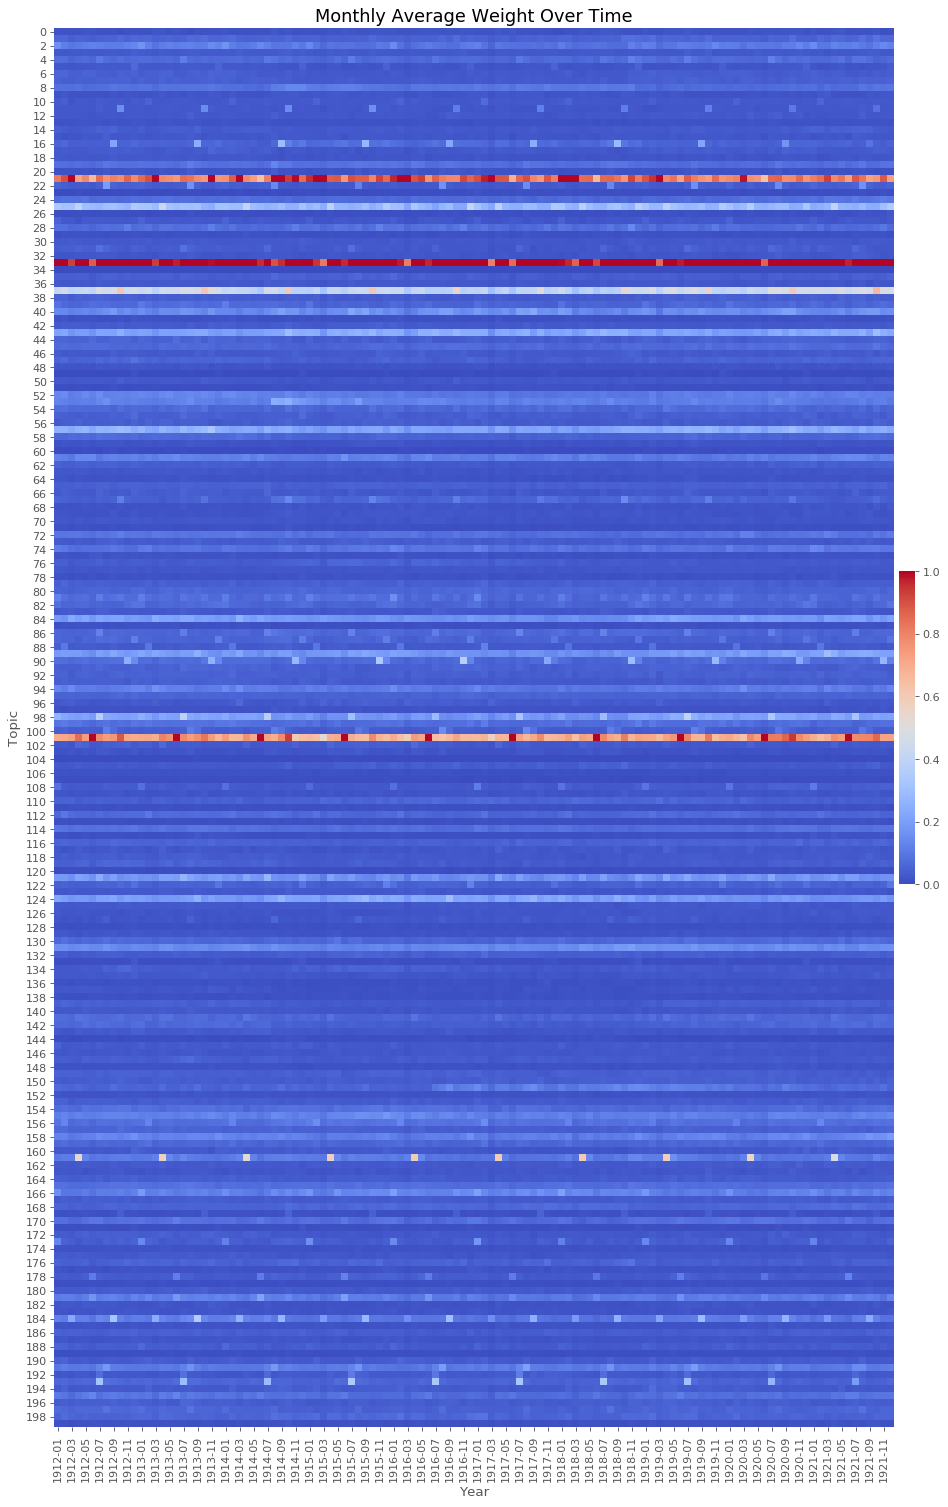

In [15]:
plot_heatmap(df_plt_scaled, title='Monthly Average Weight Over Time')

### 3.5 Monthly Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

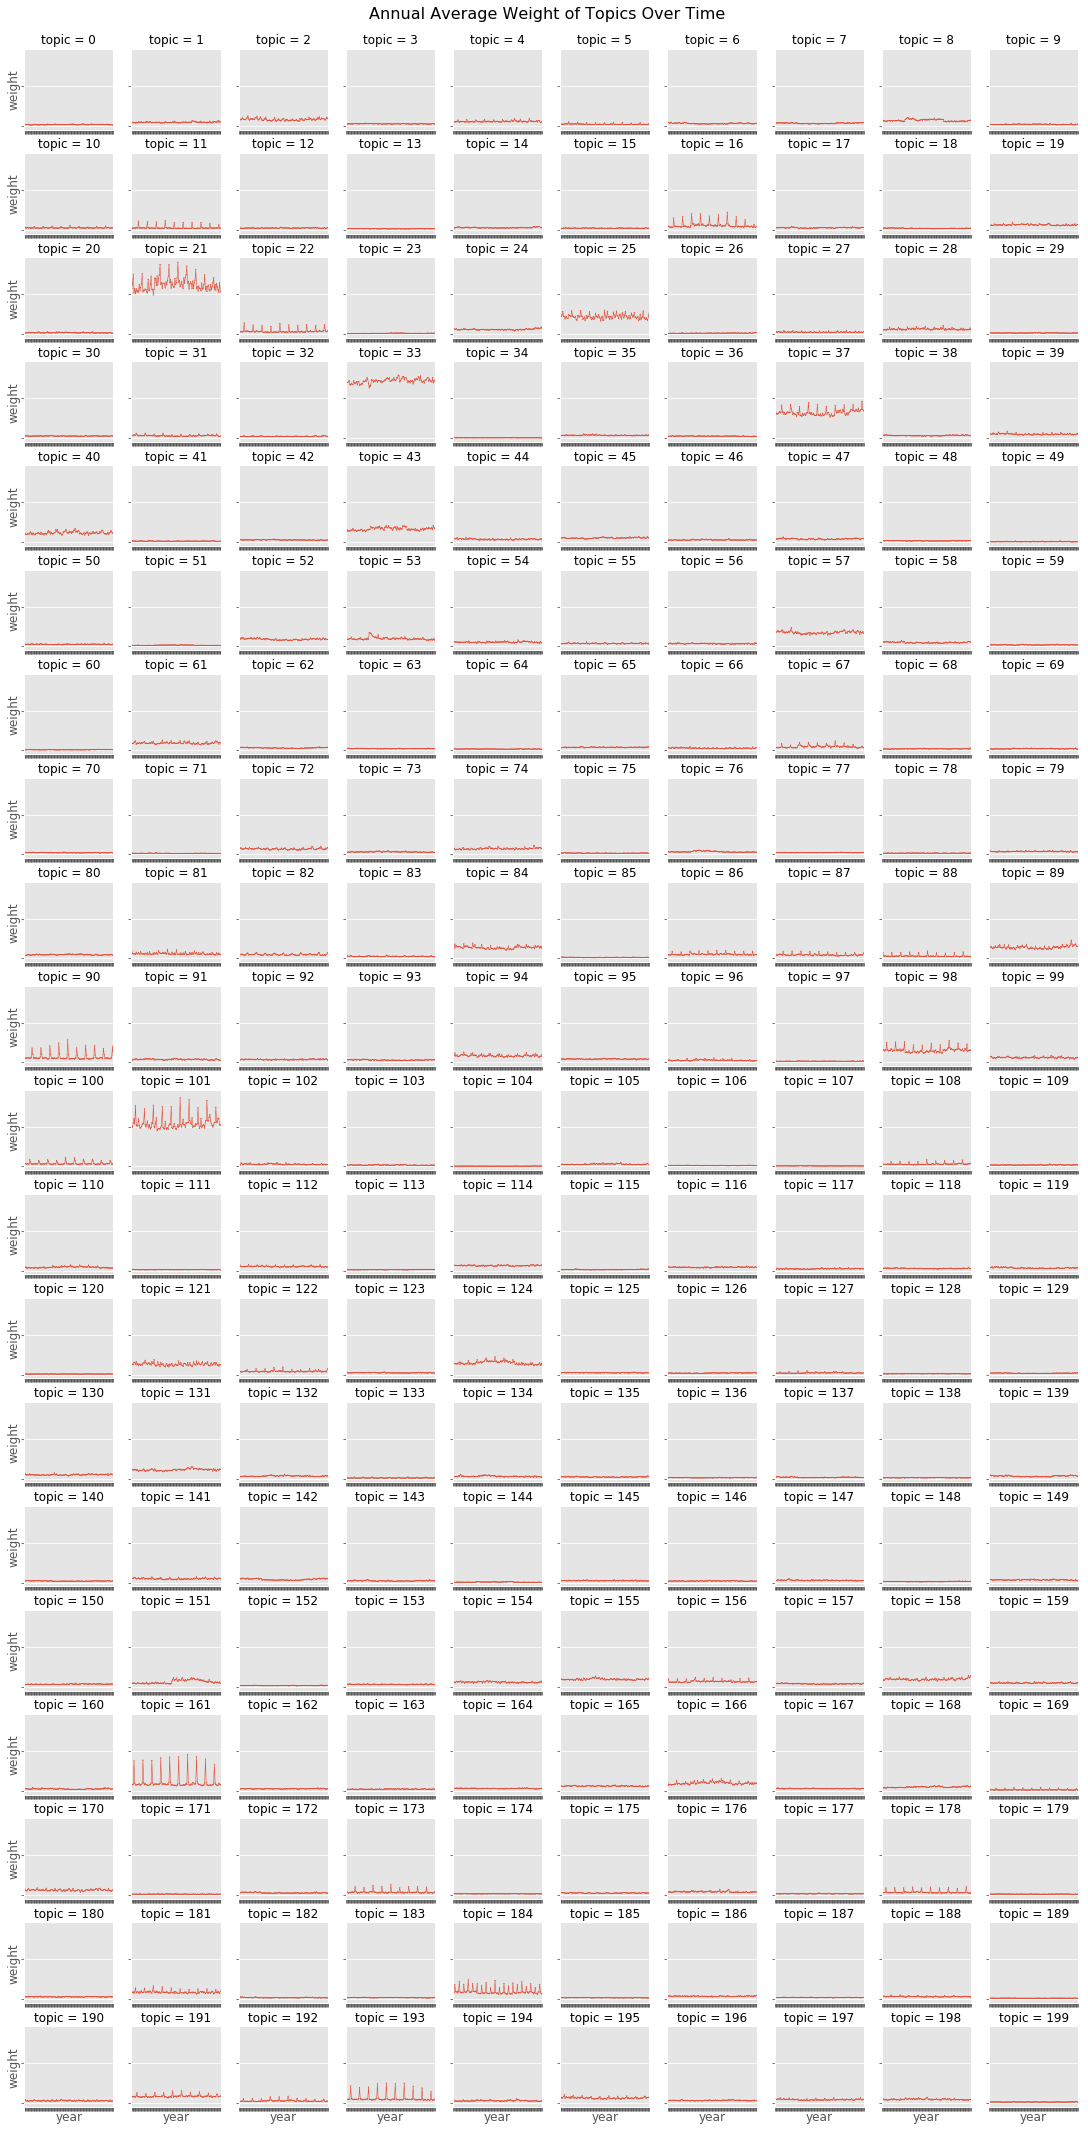

In [16]:
plot_avg(df_avgweight)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [17]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (12541, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
0,0.001607,train railway leave trains station passengers return dep day tickets service stations express run railways fares spe...
1,0.004432,prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...
2,0.008014,time good year made great present work years fact number past season week large make place success doubt interest ago
3,0.002558,plaintiff defendant claim court costs judgment case witness evidence paid amount pay appeared gave made plaintiffs c...
4,0.005621,found death body deceased man inquest dead named evidence witness died suicide morning murder wife returned house ve...
5,0.002124,sale harness horses horse draught farm cows stock good cattle mare dairy plough sell cart years spring gelding instr...
6,0.002993,motor masterton street car cycle phone cars prices advertisements tyres column price cycles good agents call stock g...
7,0.003220,board committee meeting chairman report received messrs letter resolved present held read decided matter reported mo...
8,0.007014,goods books fancy christmas stock cases large sets presents xmas assortment cards prices toys variety boxes statione...


**Dominant topics distribution by month:**

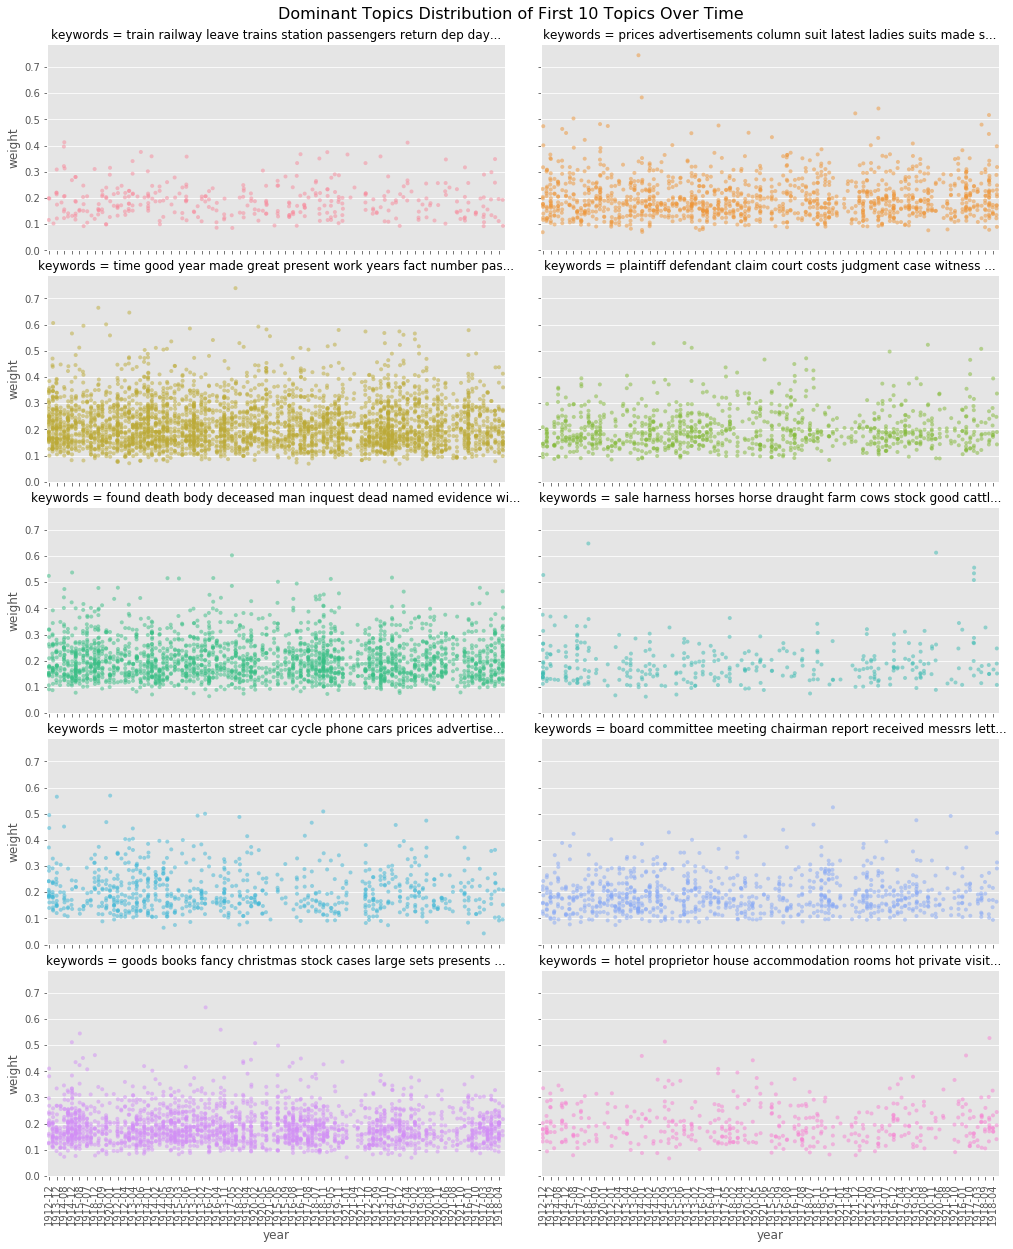

In [18]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

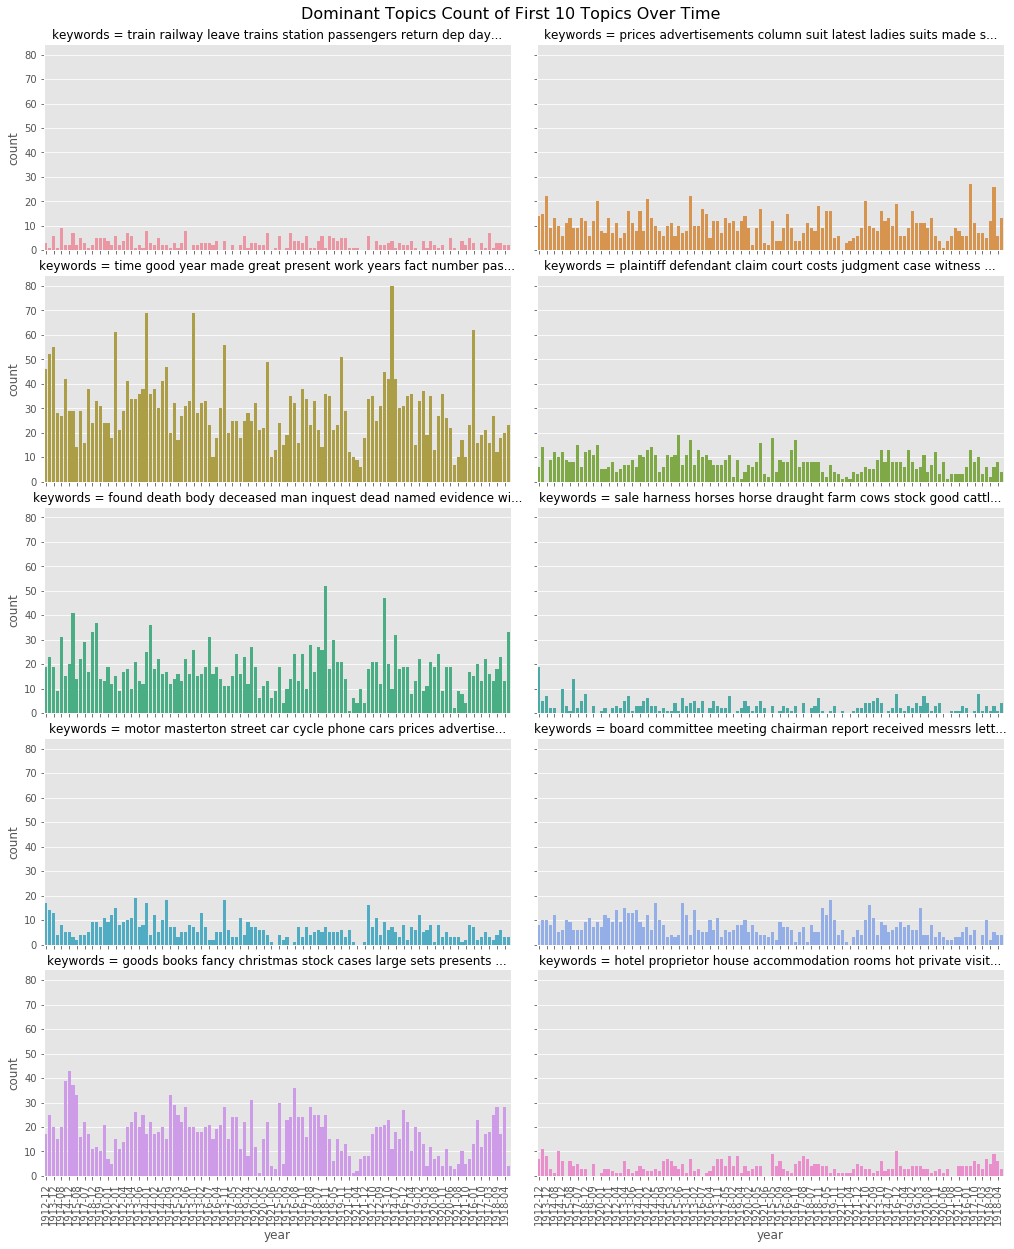

In [19]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

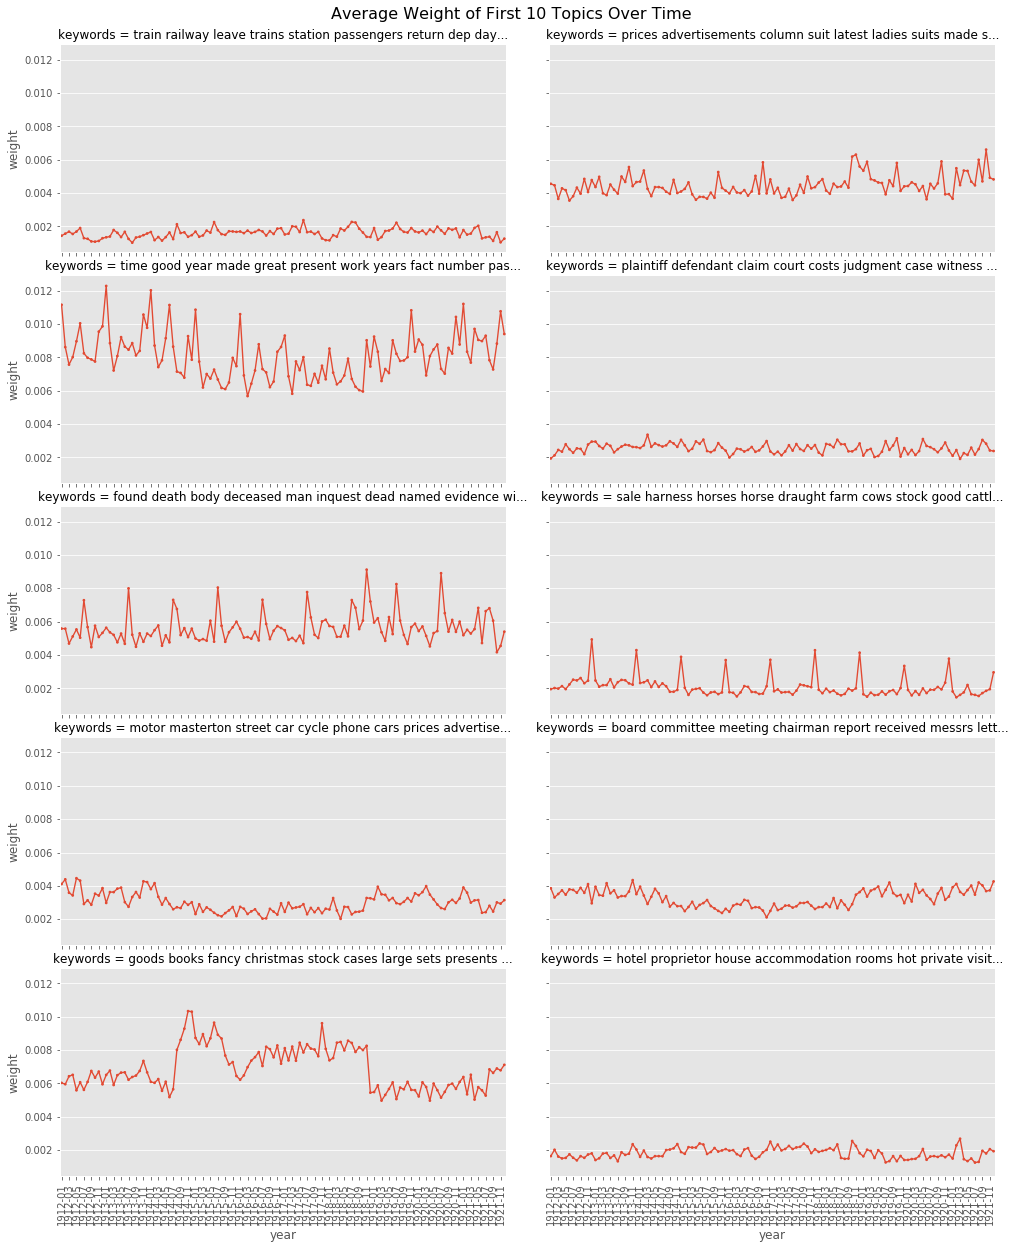

In [20]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [21]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [21, 101, 33, 37, 161, 25, 90, 98, 184, 43]
Shape of df_plt_dom: (311745, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
21,0.062684,public time present question people great fact matter good made country case men position government doubt opinion m...
101,0.054450,years london great man english time england made ago year life lady young world day french long paris found days
33,0.072091,tin ill oil lit mil day zealand ton tie hat aro fur aid tins ail end man hut til time
37,0.032006,love day life heart thy eyes light long night sweet home great world sun thou beautiful bright man sea beauty
161,0.010743,powder chemist medicines sold medical remedy hair bottle medicine chemists pills london teeth oil powders prepared c...
25,0.021927,man head back time feet long dog hand made side left round men body found horse ground water hands put
90,0.006848,crops crop good soil wheat farmers time land season year ground weather grass bushels seed acre farm dry sheep farmer
98,0.015382,business public notice begs attention orders inform premises patronage general support stock undersigned advertiseme...
184,0.009726,police killed arrested received london men shot prisoners women murder wounded soldiers death paris persons troops c...


**Dominant topics distribution by Month:**

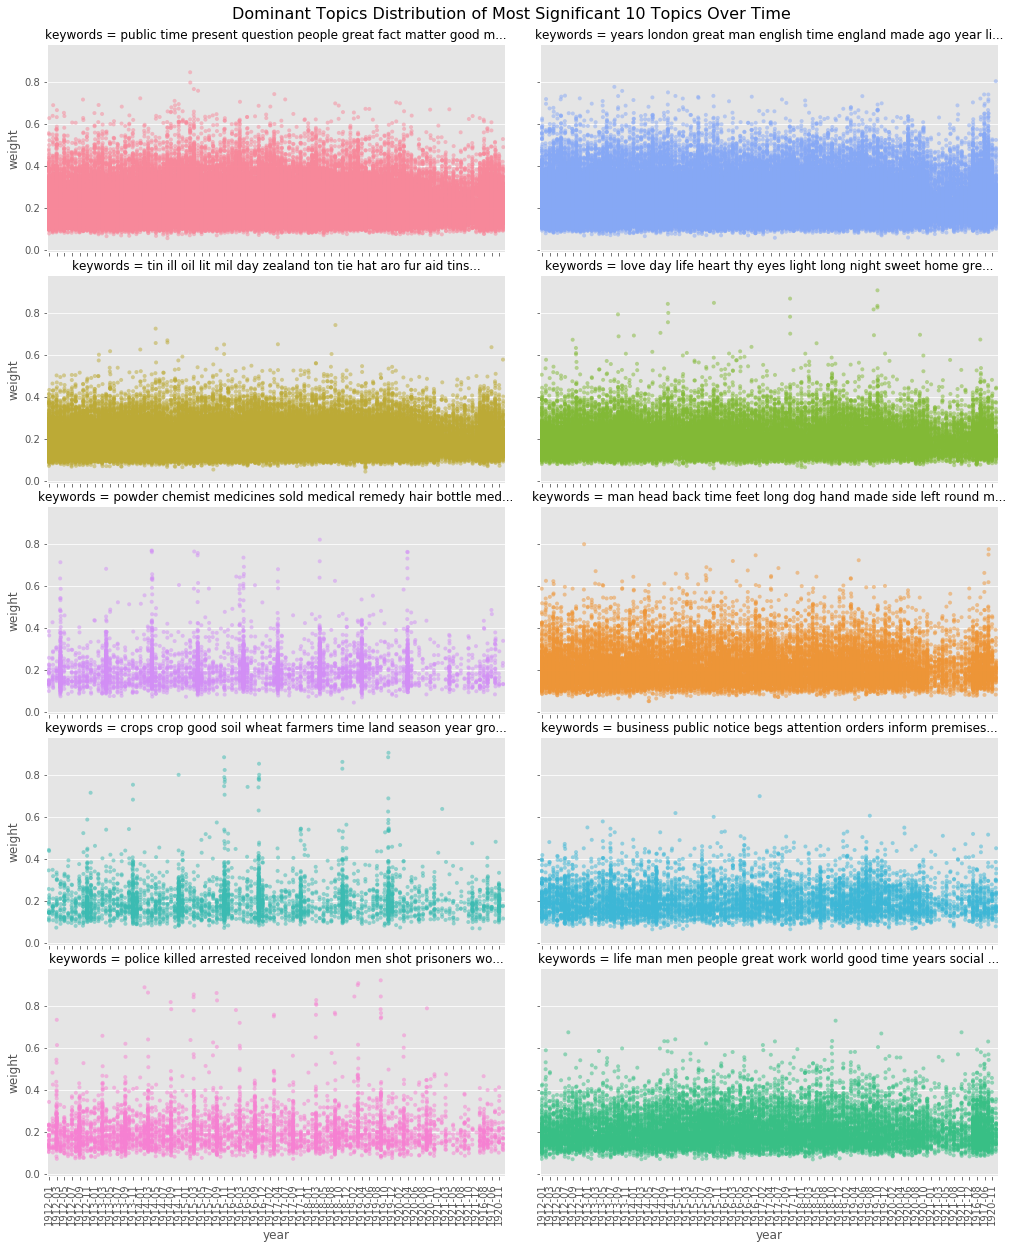

In [22]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

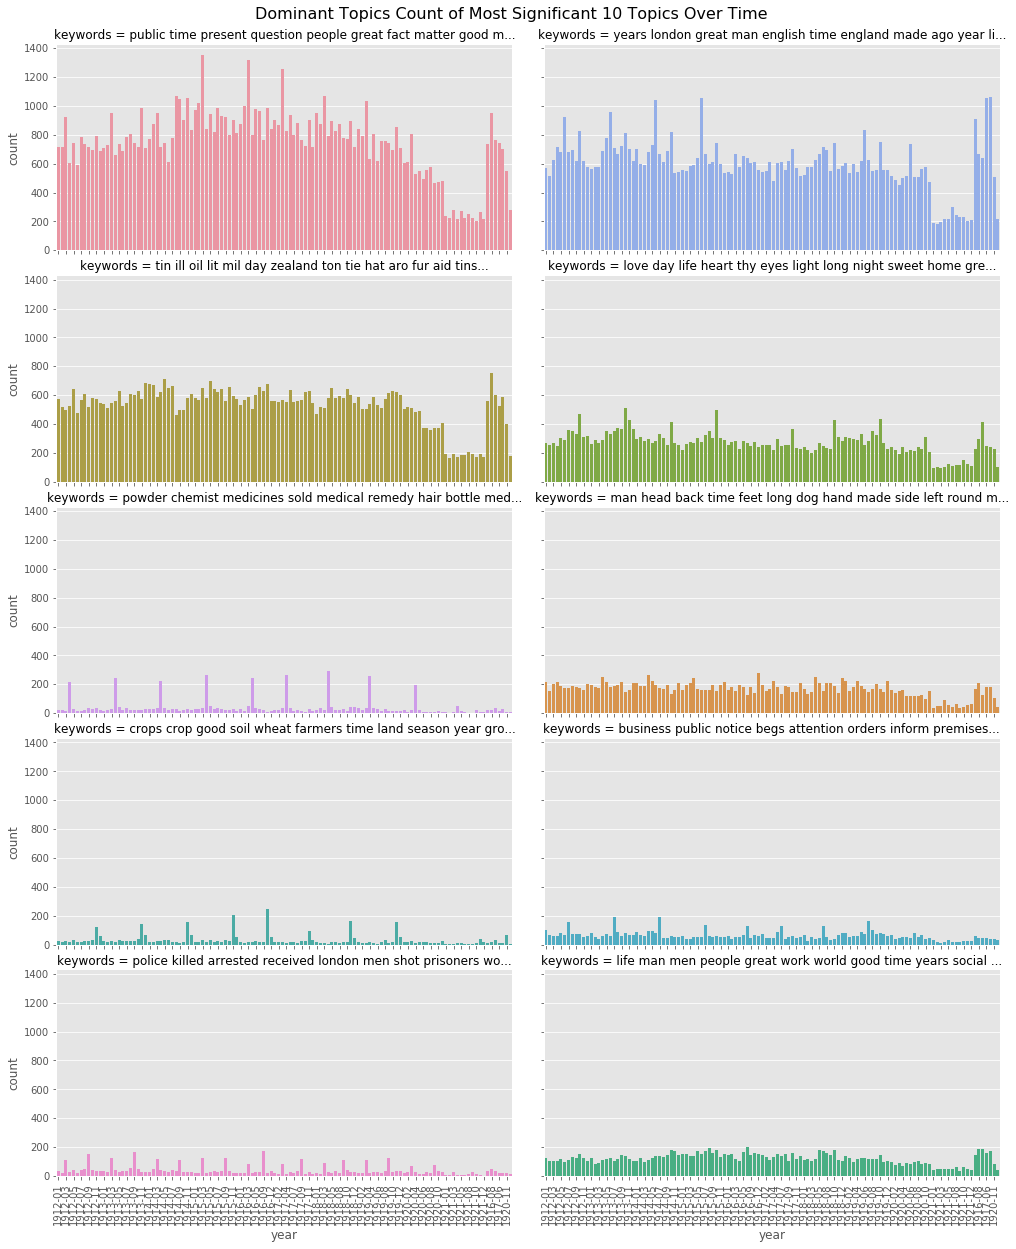

In [23]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

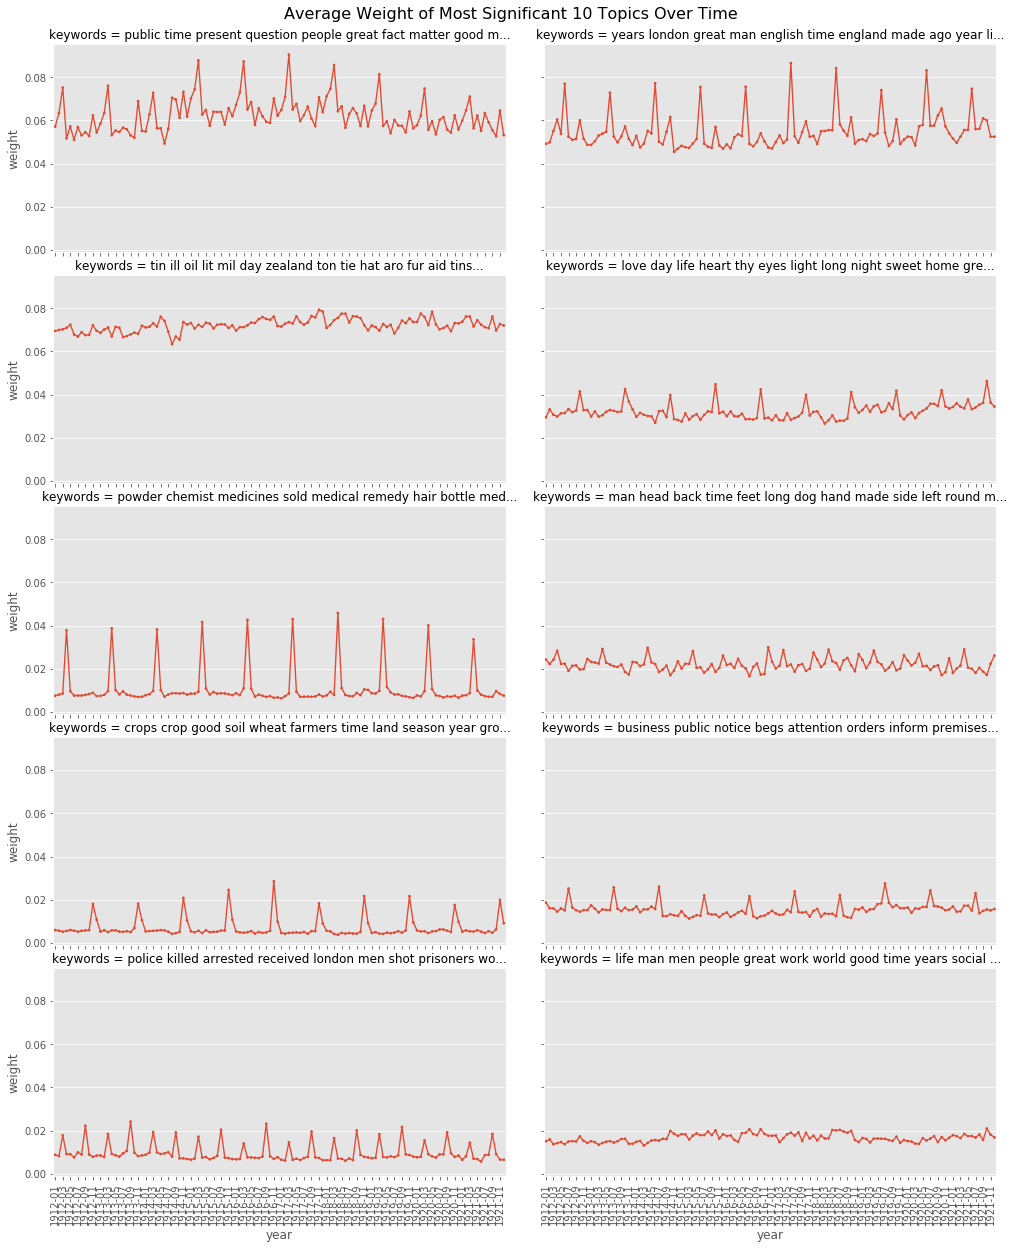

In [24]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

**By compare the topic weight in topic list, we can find out which topics are the most different in WWI. Here we are interested in both trend (the more or less popular topics) in WWI.**

In [25]:
path = r'../models/wwi/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare and contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [77, 29, 179, 59, 51, 34, 127, 41, 128, 163]
Shape of df_plt_dom: (1834, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
77,0.002120,association press received telegraph copyright london united july electric cable june sydney august april march aust...
29,0.001223,mails mail close office letters auckland notices united_kingdom chief wellington post late europe london due fee con...
179,0.000947,weather rain wind winds moderate hours strong barometer light heavy to-day cape gale forecast breeze sea south fine ...
59,0.001593,wellington nelson morning to-morrow arrived saturday tons westport moon picton leaves coast wednesday to-day monday ...
51,0.001111,south africa boers british war general transvaal contingent boer london lord received african cape capetown men troo...
34,0.000292,rooms price section large bungalow terms modern deposit home good bay gas residence view tram garage house kitchenet...
127,0.002155,arrived tons port wellington sailed auckland schooner cargo yesterday melbourne left barque passengers lyttelton syd...
41,0.001184,team game play match football played ball goal good rugby forwards points saturday players wellington teams ground s...
128,0.001067,beat club played play game match tennis won championship round players tournament games golf bowling skip green cup ...


**Dominant topics distribution by month:**

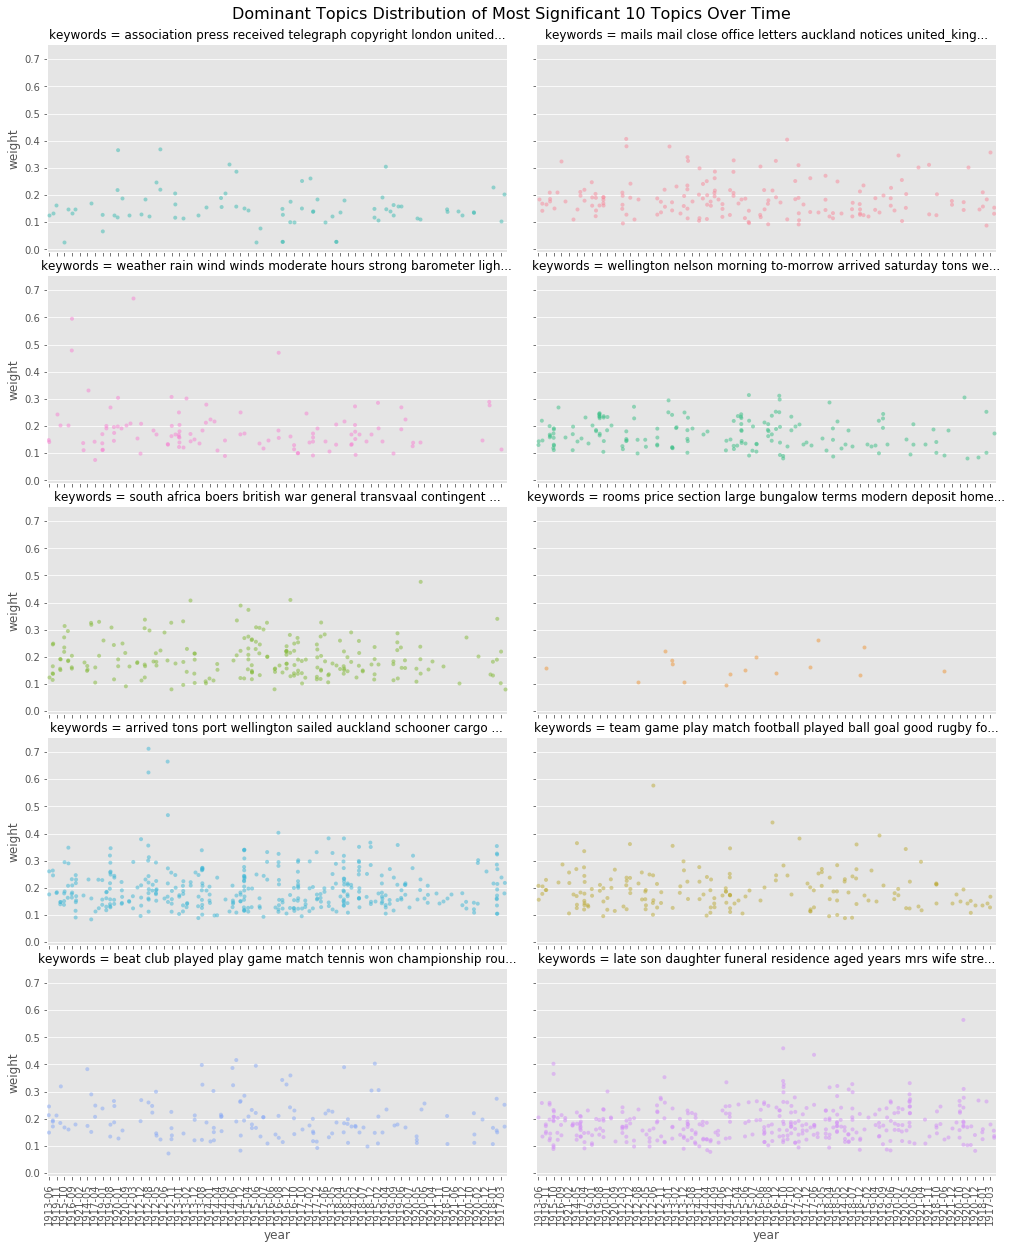

In [26]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

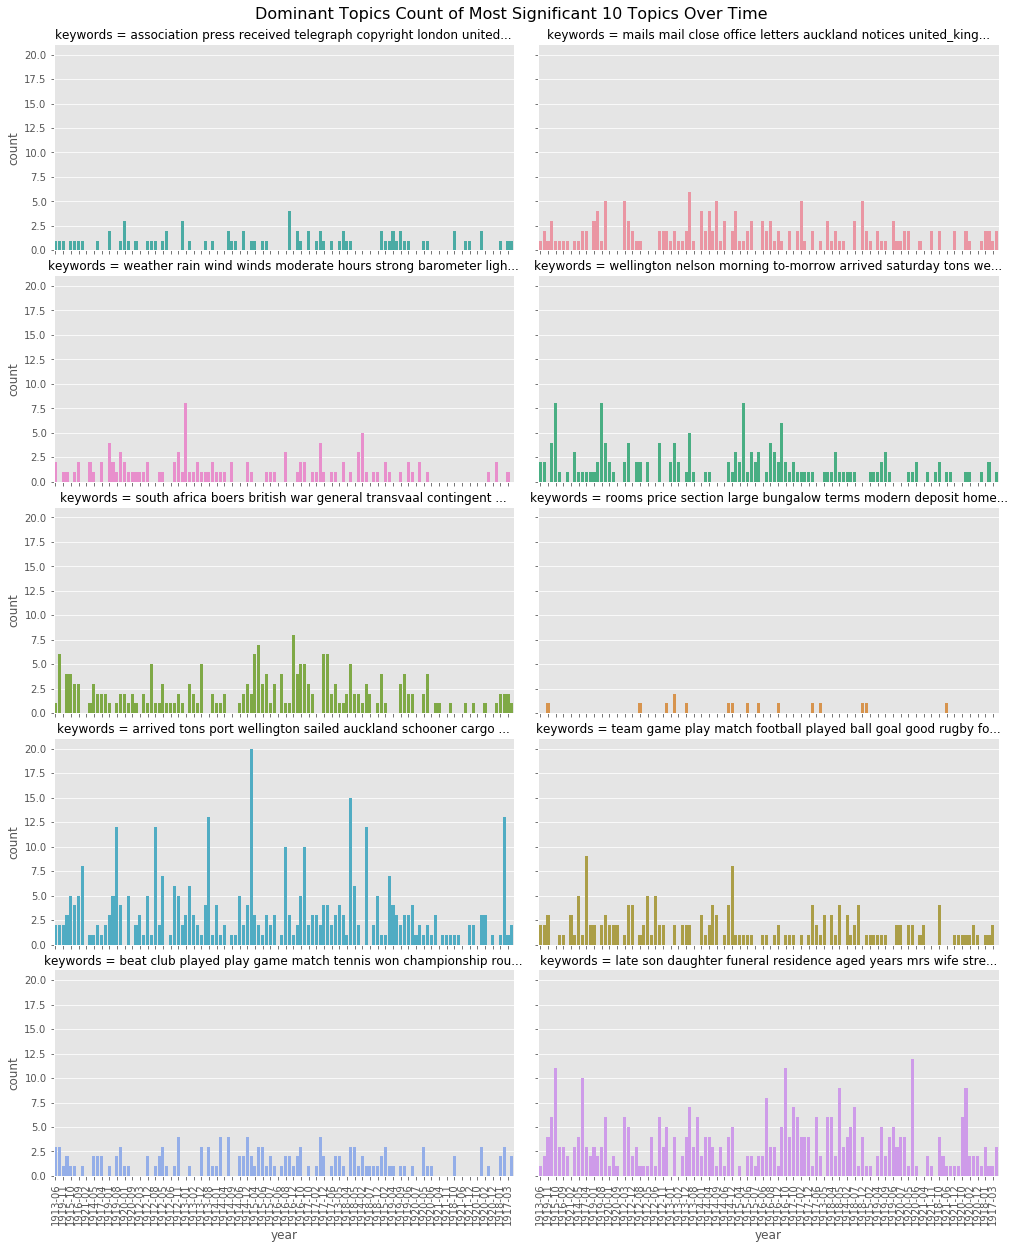

In [27]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

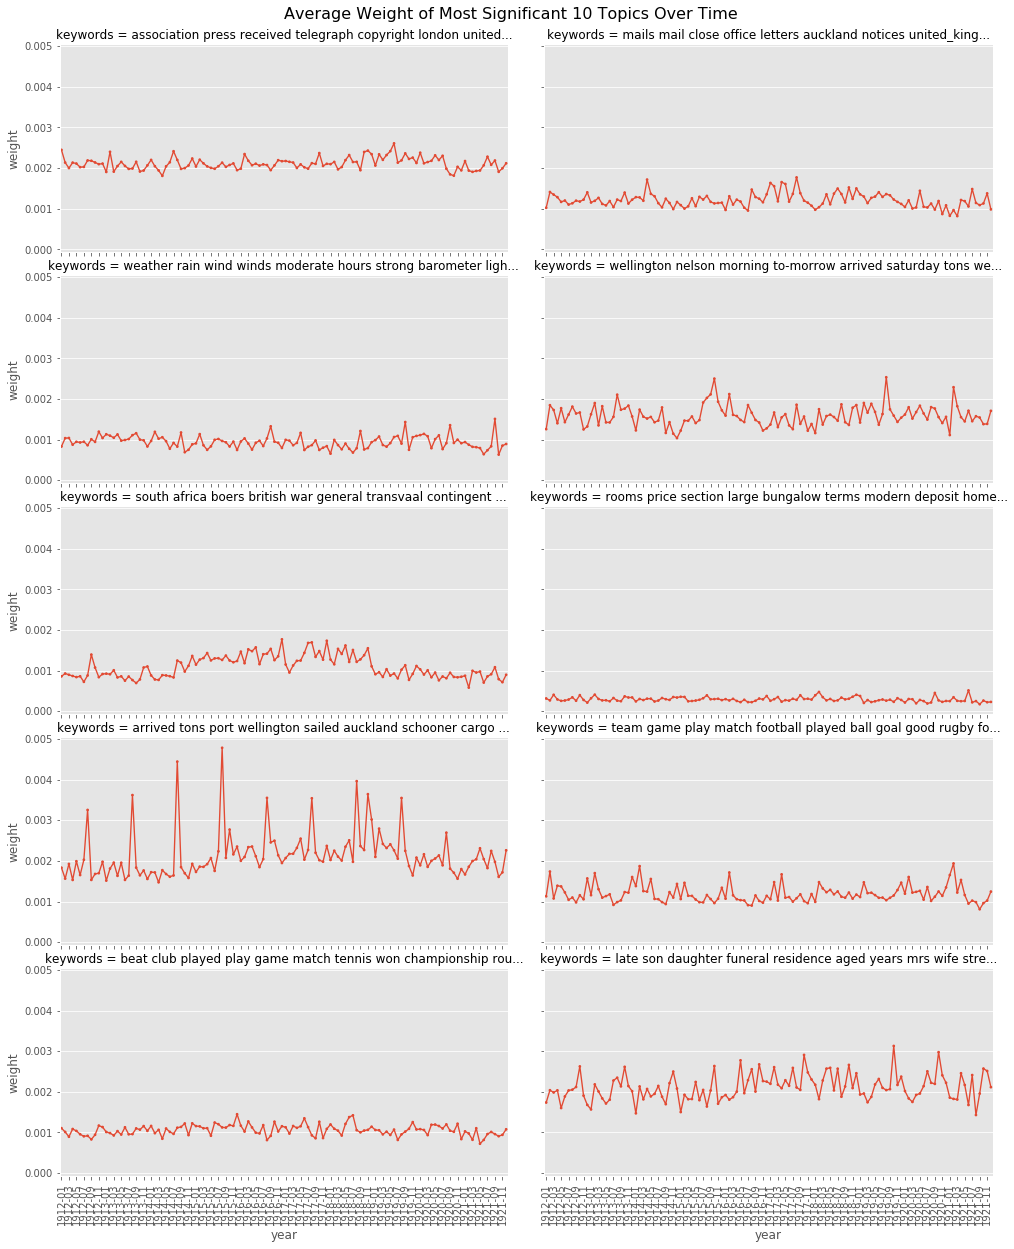

In [28]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

---

In [29]:
gc.collect()

235